In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.models import efficientnet_b0
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm

In [ ]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
# ---------------- Dataset ----------------
class TrafficSignDataset(Dataset):
    def __init__(self, data):
        self.data = data
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        img, label = self.data[idx]
        return img, label

with open("train_tensor_data.pkl", "rb") as f:
    train_data = pickle.load(f)
with open("test_tensor_data.pkl", "rb") as f:
    test_data = pickle.load(f)

# Wrap as Dataset
full_train_dataset = TrafficSignDataset(train_data)
test_dataset = TrafficSignDataset(test_data)

# Split train/val
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [8]:
# ---------------- Train Function ----------------
def train_model(model, epochs=5, lr=1e-3, unfreeze=False):
    if unfreeze:
        for param in model.features[-20:]:
            param.requires_grad = True
    else:
        for param in model.features.parameters():
            param.requires_grad = False

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

    best_train_acc = 0
    best_val_acc = 0
    train_accs, val_accs = [], []

    for epoch in range(epochs):
        # Train
        model.train()
        correct, total = 0, 0
        for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            preds = model(x)
            loss = criterion(preds, y)
            loss.backward()
            optimizer.step()

            correct += (preds.argmax(1) == y).sum().item()
            total += y.size(0)
        acc = correct / total
        train_accs.append(acc)
        best_train_acc = max(best_train_acc, acc)

        # Val
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                preds = model(x)
                correct += (preds.argmax(1) == y).sum().item()
                total += y.size(0)
        acc = correct / total
        val_accs.append(acc)
        best_val_acc = max(best_val_acc, acc)

    return train_accs, val_accs, best_train_acc, best_val_acc

In [9]:
# ---------------- Phase 1: Frozen ----------------
model1 = efficientnet_b0(pretrained=True)
model1.classifier[1] = nn.Linear(model1.classifier[1].in_features, 23)
model1.to(device)

train_accs1, val_accs1, best_train1, best_val1 = train_model(model1, epochs=5, lr=1e-3, unfreeze=False)

# ---------------- Phase 2: Fine-tune ----------------
model2 = efficientnet_b0(pretrained=True)
model2.classifier[1] = nn.Linear(model2.classifier[1].in_features, 23)
model2.to(device)

# Load weights from model1
model2.load_state_dict(model1.state_dict())

train_accs2, val_accs2, best_train2, best_val2 = train_model(model2, epochs=5, lr=1e-4, unfreeze=True)

Epoch 5/5: 100%|██████████| 98/98 [00:08<00:00, 11.74it/s]


In [10]:
# ---------------- Test Accuracy ----------------
def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            preds = model(x)
            correct += (preds.argmax(1) == y).sum().item()
            total += y.size(0)
    return correct / total

test_acc1 = evaluate(model1, test_loader)
test_acc2 = evaluate(model2, test_loader)

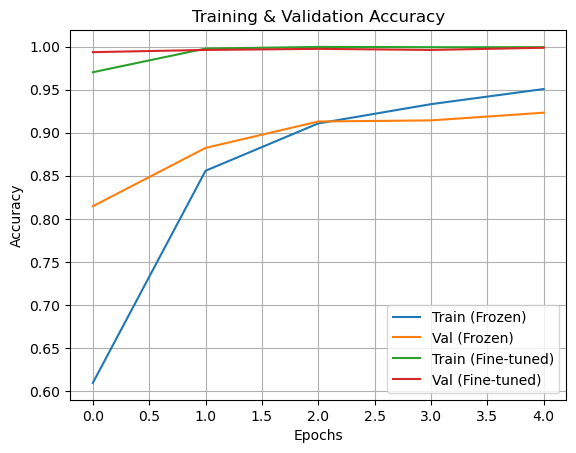

In [11]:
# ---------------- Plot ----------------
plt.plot(train_accs1, label="Train (Frozen)")
plt.plot(val_accs1, label="Val (Frozen)")
plt.plot(train_accs2, label="Train (Fine-tuned)")
plt.plot(val_accs2, label="Val (Fine-tuned)")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# ---------------- Report ----------------
print(f"Best Train Accuracy (Frozen):     {best_train1:.4f}")
print(f"Best Val Accuracy (Frozen):       {best_val1:.4f}")
print(f"Test Accuracy (Frozen):           {test_acc1:.4f}")
print()
print(f"Best Train Accuracy (Fine-tuned): {best_train2:.4f}")
print(f"Best Val Accuracy (Fine-tuned):   {best_val2:.4f}")
print(f"Test Accuracy (Fine-tuned):       {test_acc2:.4f}")

Best Train Accuracy (Frozen):     0.9508
Best Val Accuracy (Frozen):       0.9233
Test Accuracy (Frozen):           0.9189

Best Train Accuracy (Fine-tuned): 0.9997
Best Val Accuracy (Fine-tuned):   0.9987
Test Accuracy (Fine-tuned):       0.9990
